# ML Model 1 – Time Series Prediction (Linear Regression)
**Project:** Single Elder Home Monitoring – Gas and Position

This notebook implements Multiple Linear Regression to predict future CO and CO₂ concentrations
using lag features, rolling statistics, environmental variables, and motion data.

This implementation aligns exactly with Assignment 4.2 progress update.

In [1]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
merged_df = pd.read_csv("merged_df_clean.csv")

merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
print("merged_df loaded successfully")

Saving merged_df_clean.csv to merged_df_clean (1).csv
merged_df loaded successfully


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# IMPORTANT: Run Christopher's EDA notebook first so merged_df exists

merged_df = pd.read_csv("merged_df_clean.csv")

# If timestamp exists:
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

print('Ready to build Model 1 (Linear Regression)')

Ready to build Model 1 (Linear Regression)


## Step 1 – Create Future Targets (1 Hour Ahead)

In [3]:
merged_df['CO_future'] = merged_df['covalue'].shift(-1)
merged_df['CO2_future'] = merged_df['co2cosirvalue'].shift(-1)

## Step 2 – Create Lag Features

In [4]:
merged_df['CO_lag1'] = merged_df['covalue'].shift(1)
merged_df['CO_lag2'] = merged_df['covalue'].shift(2)
merged_df['CO_lag3'] = merged_df['covalue'].shift(3)

merged_df['CO2_lag1'] = merged_df['co2cosirvalue'].shift(1)
merged_df['CO2_lag2'] = merged_df['co2cosirvalue'].shift(2)
merged_df['CO2_lag3'] = merged_df['co2cosirvalue'].shift(3)

## Step 3 – Create Rolling Statistics

In [5]:
merged_df['CO_roll_mean'] = merged_df['covalue'].rolling(window=3).mean()
merged_df['CO_roll_std'] = merged_df['covalue'].rolling(window=3).std()

merged_df['CO2_roll_mean'] = merged_df['co2cosirvalue'].rolling(window=3).mean()
merged_df['CO2_roll_std'] = merged_df['co2cosirvalue'].rolling(window=3).std()

## Step 4 – Remove Missing Values

In [6]:
merged_df = merged_df.dropna()

## Step 5 – Define Feature Sets

In [7]:
features_co = [
    'CO_lag1','CO_lag2','CO_lag3',
    'CO_roll_mean','CO_roll_std',
    'temperature','humidity',
    'co2cosirvalue','movement'
]

features_co2 = [
    'CO2_lag1','CO2_lag2','CO2_lag3',
    'CO2_roll_mean','CO2_roll_std',
    'temperature','humidity',
    'covalue','movement'
]

X_co = merged_df[features_co]
y_co = merged_df['CO_future']

X_co2 = merged_df[features_co2]
y_co2 = merged_df['CO2_future']

## Step 6 – Chronological Train/Test Split

In [8]:
split_index = int(len(merged_df) * 0.8)

X_co_train = X_co.iloc[:split_index]
X_co_test = X_co.iloc[split_index:]
y_co_train = y_co.iloc[:split_index]
y_co_test = y_co.iloc[split_index:]

X_co2_train = X_co2.iloc[:split_index]
X_co2_test = X_co2.iloc[split_index:]
y_co2_train = y_co2.iloc[:split_index]
y_co2_test = y_co2.iloc[split_index:]

print("Total samples:", len(merged_df))
print("Training samples:", len(X_co_train))
print("Testing samples:", len(X_co_test))

print("\nTraining %:", len(X_co_train)/len(merged_df))
print("Testing  %:", len(X_co_test)/len(merged_df))

Total samples: 2307
Training samples: 1845
Testing samples: 462

Training %: 0.7997399219765929
Testing  %: 0.20026007802340703


## Step 7 – Feature Scaling

In [9]:
scaler_co = StandardScaler()
X_co_train_scaled = scaler_co.fit_transform(X_co_train)
X_co_test_scaled = scaler_co.transform(X_co_test)

scaler_co2 = StandardScaler()
X_co2_train_scaled = scaler_co2.fit_transform(X_co2_train)
X_co2_test_scaled = scaler_co2.transform(X_co2_test)

## Step 8 – Train Linear Regression Models

In [10]:
model_co = LinearRegression()
model_co.fit(X_co_train_scaled, y_co_train)

model_co2 = LinearRegression()
model_co2.fit(X_co2_train_scaled, y_co2_train)

LinearRegression()

## Step 9 – Evaluate Models

In [11]:
y_co_pred = model_co.predict(X_co_test_scaled)
y_co2_pred = model_co2.predict(X_co2_test_scaled)

mae_co = mean_absolute_error(y_co_test, y_co_pred)
rmse_co = np.sqrt(mean_squared_error(y_co_test, y_co_pred))
r2_co = r2_score(y_co_test, y_co_pred)

mae_co2 = mean_absolute_error(y_co2_test, y_co2_pred)
rmse_co2 = np.sqrt(mean_squared_error(y_co2_test, y_co2_pred))
r2_co2 = r2_score(y_co2_test, y_co2_pred)

print('CO Model -> MAE:', mae_co, 'RMSE:', rmse_co, 'R2:', r2_co)
print('CO2 Model -> MAE:', mae_co2, 'RMSE:', rmse_co2, 'R2:', r2_co2)

CO Model -> MAE: 5.114298825330494 RMSE: 7.655385333992481 R2: 0.8610855847232892
CO2 Model -> MAE: 5.777934606355737 RMSE: 8.020908866989311 R2: 0.909041954839766


## Step 10 – Professional Visualization (Report-Ready Figures)
This section generates high-resolution figures for inclusion in the final report.

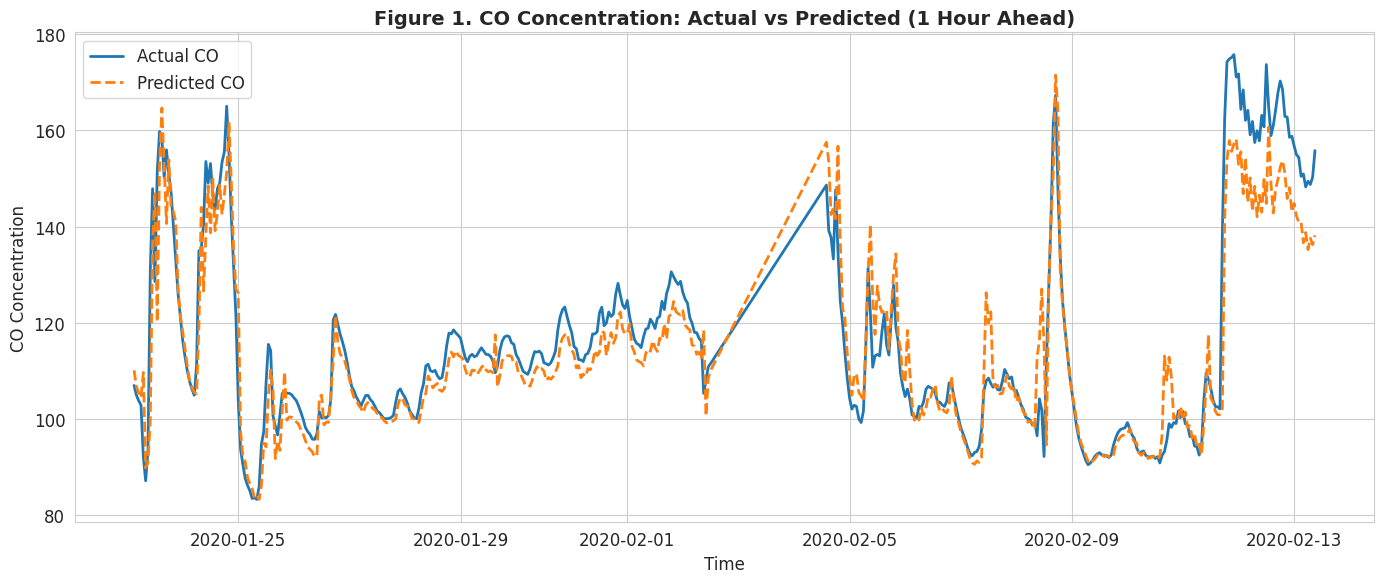

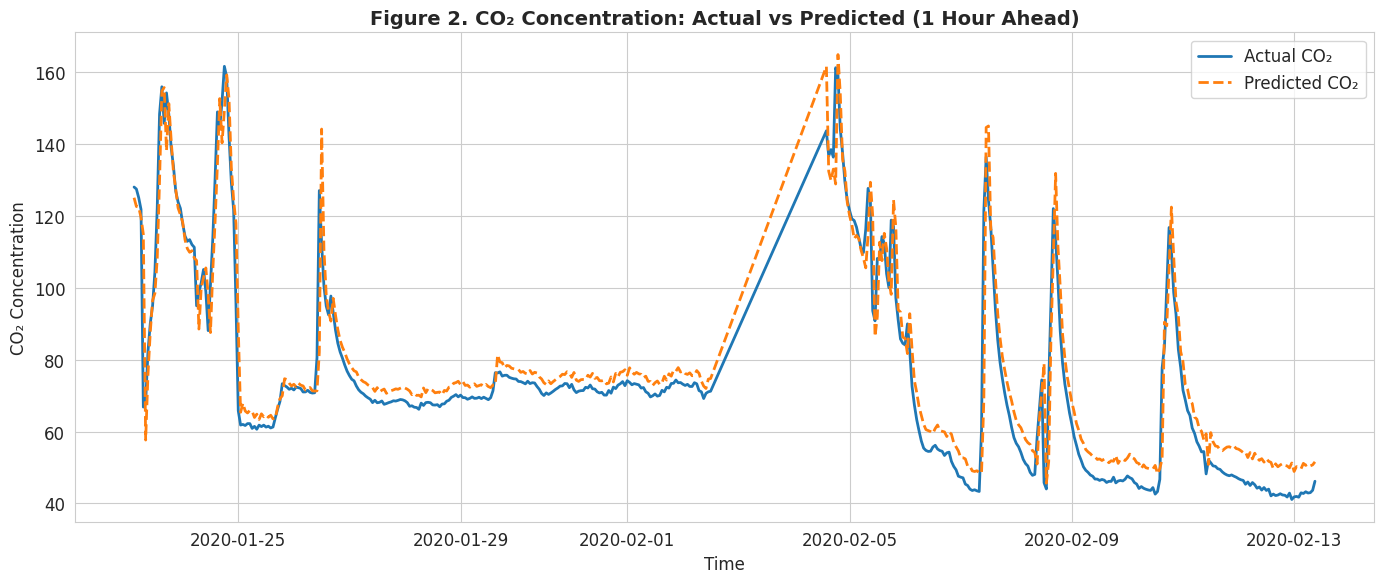

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 12

# Get timestamps
timestamps_test = merged_df['timestamp'].iloc[split_index:]

# -------- CO Time Series --------
plt.figure()
plt.plot(timestamps_test, y_co_test.values, label='Actual CO', linewidth=2)
plt.plot(timestamps_test, y_co_pred, label='Predicted CO', linewidth=2, linestyle='--')
plt.title('Figure 1. CO Concentration: Actual vs Predicted (1 Hour Ahead)', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('CO Concentration')
plt.legend()
plt.tight_layout()
plt.savefig('Figure1_CO_Prediction.png', dpi=300)
plt.show()

# -------- CO2 Time Series --------
plt.figure()
plt.plot(timestamps_test, y_co2_test.values, label='Actual CO₂', linewidth=2)
plt.plot(timestamps_test, y_co2_pred, label='Predicted CO₂', linewidth=2, linestyle='--')
plt.title('Figure 2. CO₂ Concentration: Actual vs Predicted (1 Hour Ahead)', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('CO₂ Concentration')
plt.legend()
plt.tight_layout()
plt.savefig('Figure2_CO2_Prediction.png', dpi=300)
plt.show()

## Step 11 – Linear Regression Coefficient Analysis
This section visualizes the magnitude of regression coefficients to interpret feature importance.

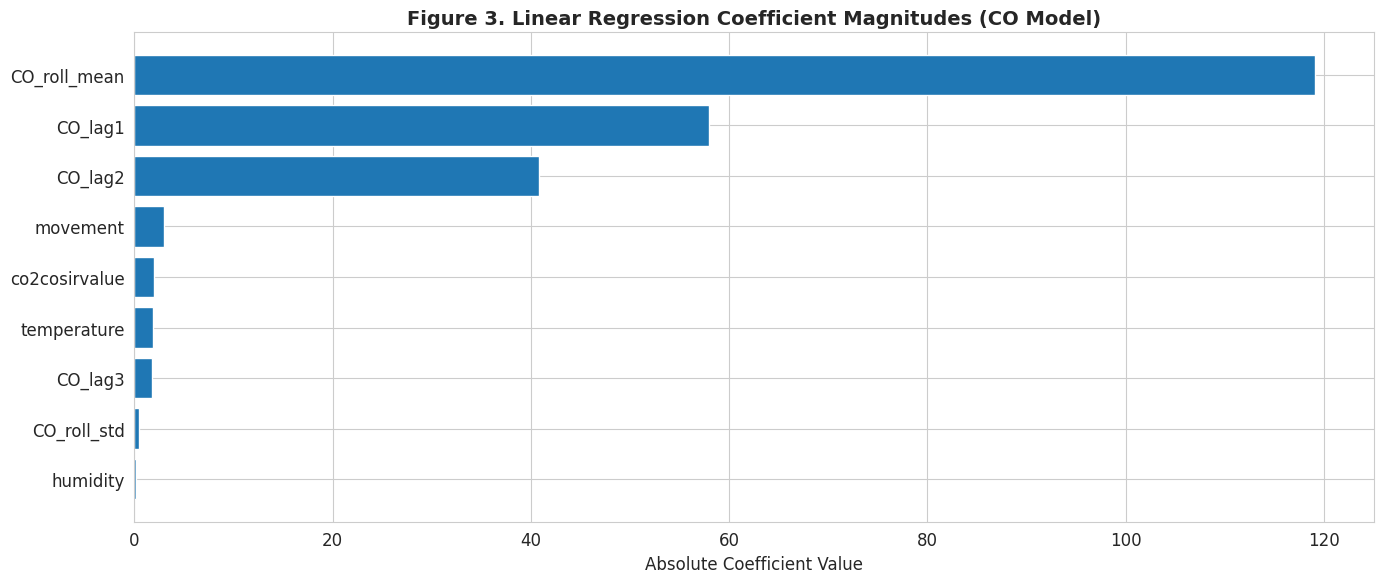

In [13]:
co_coefficients = pd.DataFrame({
    'feature': features_co,
    'coefficient': model_co.coef_
}).sort_values('coefficient', key=abs, ascending=True)

plt.figure()
plt.barh(co_coefficients['feature'], abs(co_coefficients['coefficient']))
plt.title('Figure 3. Linear Regression Coefficient Magnitudes (CO Model)', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.savefig('Figure3_CO_Coefficients.png', dpi=300)
plt.show()

## Step 12 – Export Predictions for Tableau dashboard
Exports predictions and performance metrics for dashboard integration.

In [14]:
predictions_df = pd.DataFrame({
    'timestamp': timestamps_test.values,
    'actual_co': y_co_test.values,
    'predicted_co': y_co_pred,
    'actual_co2': y_co2_test.values,
    'predicted_co2': y_co2_pred
})

predictions_df.to_csv('gas_predictions_model1.csv', index=False)

performance_df = pd.DataFrame({
    'Model': ['CO Linear Regression', 'CO2 Linear Regression'],
    'MAE': [mae_co, mae_co2],
    'RMSE': [rmse_co, rmse_co2],
    'R2': [r2_co, r2_co2]
})

performance_df.to_csv('model1_performance.csv', index=False)

print('Exports completed successfully.')

Exports completed successfully.
